In [2]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2021-03-17 04:43:38--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [3]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import io


In [4]:
#Use to import pandas
import pandas as pd
#Use to import the file into google Colab drive
from google.colab import files 
#Use to import io, which opens the file from the Colab drive
import io

In [11]:
uploaded = files.upload()

Saving EXCAPE.csv to EXCAPE (1).csv


In [12]:
excape = pd.read_csv(io.StringIO(uploaded['EXCAPE.csv'].decode('utf-8')))

In [15]:
uploaded = files.upload()

Saving ChEMBL.csv to ChEMBL (2).csv


In [17]:
chembl = pd.read_csv(io.StringIO(uploaded['ChEMBL.csv'].decode('ISO-8859-1')))

In [18]:
uploaded = files.upload()

Saving DTC.csv to DTC.csv


In [19]:
dtc = pd.read_csv(io.StringIO(uploaded['DTC.csv'].decode('utf-8')))

In [20]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

In [21]:
dtc.iloc[1:3,1:10]

,Uniprot ID,Compound Name,Standard inchi key,Max Phase,Target Pref Name,Gene Names,Target Class,Wild type or mutant,Mutation information
1,P35368,NaN,LXIPAAJKLDMQAA-UHFFFAOYSA-N,0,ALPHA-1B ADRENERGIC RECEPTOR,ADRA1B,GPCR,NaN,NaN
2,P35368,NaN,IPEWCJVARRJXDP-UHFFFAOYSA-N,0,ALPHA-1B ADRENERGIC RECEPTOR,ADRA1B,GPCR,NaN,NaN


In [22]:
excape.iloc[1:3,1:15]

,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
1,CHEMBL30713,147,A,5.00,chembl20,964972,9606,ADRA1B,93,C1(=CNC2=C1C=CC=C2)CC(N)C
2,CHEMBL1076,24173,N,4.07,chembl20,911062,10116,ADRA1B,93,C1(=C(C=CC(=C1)OC)OC)C(O)CN


In [23]:
chembl.iloc[1:3,1:10]

,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation
1,NaN,0.0,459.51,0,2.75,10,COc1cc2nc(N3CCC[C@H](NC4=CC(=O)c5ccccc5C4=O)C3...,Ki,'='
2,NaN,0.0,482.65,0,3.76,6cis,CC(C)Oc1ccccc1N1CCN([C@H]2CC[C@@H](NS(=O)(=O)c...,Ki,'='


Examine data

In [24]:
chembl.columns = chembl.columns.str.replace(' ','_')
dtc.columns = dtc.columns.str.replace(' ','_')
excape.columns = excape.columns.str.replace(' ','_')

print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(2791, 45)
(2442, 43)
(1254, 11)


In [26]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4539943,NaN,0.0,505.57,1,3.6,None,O=C(c1ccc(OCCC2CCOCC2)cc1)[C@@H]1CC[C@H](Cn2nn...,Inhibition,'=',6.2900,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507829,GPCRScan assay: inhibition of Alpha1B,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,Parental cells: stable HEK | PMID: 7780636/168...,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507264,54.0,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,None,Compound concentration None 10.0 uM
1,CHEMBL4163587,NaN,0.0,459.51,0,2.75,10,COc1cc2nc(N3CCC[C@H](NC4=CC(=O)c5ccccc5C4=O)C3...,Ki,'=',0.5248,nM,9.28,NaN,NaN,UO_0000065,20.20,0.37,6.53,7.75,False,CHEMBL4139219,Displacement of [3H]prazosin from human alpha1...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4138091,1.0,Scientific Literature,Eur J Med Chem,2017.0,None,NaN
2,CHEMBL234679,NaN,0.0,482.65,0,3.76,6cis,CC(C)Oc1ccccc1N1CCN([C@H]2CC[C@@H](NS(=O)(=O)c...,Ki,'=',217.0000,nM,6.66,NaN,NaN,UO_0000065,13.81,0.27,2.90,7.78,False,CHEMBL894517,Binding affinity to human cloned adrenergic al...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148021,1.0,Scientific Literature,Bioorg. Med. Chem. Lett.,2007.0,None,NaN
3,CHEMBL15245,YOHIMBINE,4.0,354.45,0,2.65,Yohimbine,COC(=O)[C@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...,Ki,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4380086,Displacement of [3H]prazosin from human recomb...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4376854,1.0,Scientific Literature,J Med Chem,2020.0,CHEMBL3308072,NaN
4,CHEMBL293980,NaN,0.0,424.37,0,3.82,70,O=C1CC2(CCCC2)CC(=O)N1CCN1CCN(c2ccc(Cl)cc2Cl)CC1,Ki,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL649208,Binding affinity constant against alpha-1B adr...,B,BAO_0000221,tissue-based format,Cavia porcellus,CHEMBL3559722,Spleen,None,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1149137,1.0,Scientific Literature,J. Med. Chem.,2004.0,None,NaN


In [27]:
chembl.Standard_Type.value_counts()

Ki                                                     1697
Inhibition                                              263
EC50                                                    257
IC50                                                    176
Max                                                      82
Activity                                                 74
Log Ki                                                   58
Max response                                             24
pK1b                                                     18
Kd                                                       13
pKb                                                      10
% Inhibition of Control Specific Binding (Mean n=2)       8
Emax                                                      7
% Ctrl                                                    5
Kb                                                        5
pKB                                                       3
Efficacy                                

EDA: assay data responses question

In [28]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4539943,NaN,0.0,505.57,1,3.6,None,O=C(c1ccc(OCCC2CCOCC2)cc1)[C@@H]1CC[C@H](Cn2nn...,Inhibition,'=',6.2900,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507829,GPCRScan assay: inhibition of Alpha1B,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,Parental cells: stable HEK | PMID: 7780636/168...,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507264,54.0,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,None,Compound concentration None 10.0 uM
1,CHEMBL4163587,NaN,0.0,459.51,0,2.75,10,COc1cc2nc(N3CCC[C@H](NC4=CC(=O)c5ccccc5C4=O)C3...,Ki,'=',0.5248,nM,9.28,NaN,NaN,UO_0000065,20.20,0.37,6.53,7.75,False,CHEMBL4139219,Displacement of [3H]prazosin from human alpha1...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4138091,1.0,Scientific Literature,Eur J Med Chem,2017.0,None,NaN
2,CHEMBL234679,NaN,0.0,482.65,0,3.76,6cis,CC(C)Oc1ccccc1N1CCN([C@H]2CC[C@@H](NS(=O)(=O)c...,Ki,'=',217.0000,nM,6.66,NaN,NaN,UO_0000065,13.81,0.27,2.90,7.78,False,CHEMBL894517,Binding affinity to human cloned adrenergic al...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1148021,1.0,Scientific Literature,Bioorg. Med. Chem. Lett.,2007.0,None,NaN
3,CHEMBL15245,YOHIMBINE,4.0,354.45,0,2.65,Yohimbine,COC(=O)[C@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...,Ki,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4380086,Displacement of [3H]prazosin from human recomb...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4376854,1.0,Scientific Literature,J Med Chem,2020.0,CHEMBL3308072,NaN
4,CHEMBL293980,NaN,0.0,424.37,0,3.82,70,O=C1CC2(CCCC2)CC(=O)N1CCN1CCN(c2ccc(Cl)cc2Cl)CC1,Ki,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL649208,Binding affinity constant against alpha-1B adr...,B,BAO_0000221,tissue-based format,Cavia porcellus,CHEMBL3559722,Spleen,None,None,NaN,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1149137,1.0,Scientific Literature,J. Med. Chem.,2004.0,None,NaN


In [29]:
chembl.Standard_Units.unique()

array(['%', 'nM', nan], dtype=object)

Curation step: change units to be the same for all responses

In [43]:
#change uM to nM
chembl['Standard_value_nM'] = np.where(chembl.Standard_Units=='uM',chembl.Standard_Value*1000,chembl.Standard_Value)

EDA: Summarize, describe,plot data for analysis

In [44]:
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,Standard_Units,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Assay_Variant_Accession,Assay_Variant_Mutation,Source_ID,Document_Year,Standard_Units_nM,Standard_value_nM
count,2785.000000,2784.000000,2782.000000,2782.000000,2.485000e+03,2.485000e+03,1642.000000,1467.000000,1467.000000,1467.000000,1467.000000,0.0,0.0,2642.000000,2501.000000,2.485000e+03,2.485000e+03
mean,0.145063,412.813222,0.340403,3.399242,4.024145e+23,4.024145e+23,7.038173,16.394206,0.312638,3.332031,11.978643,NaN,NaN,3.828539,2006.579368,4.024145e+23,4.024145e+23
std,0.734366,119.475701,0.614648,1.352475,2.006027e+25,2.006027e+25,1.062484,5.145562,0.096922,1.790309,14.260014,NaN,NaN,11.914935,6.825643,2.006027e+25,2.006027e+25
min,0.000000,156.180000,0.000000,-1.630000,-3.163000e+01,-3.163000e+01,4.000000,6.960000,0.130000,-3.250000,2.610000,NaN,NaN,1.000000,1994.000000,-3.163000e+01,-3.163000e+01
25%,0.000000,312.107500,0.000000,2.500000,1.862000e+01,1.862000e+01,6.350000,12.540000,0.240000,2.125000,7.355000,NaN,NaN,1.000000,2001.000000,1.862000e+01,1.862000e+01
50%,0.000000,419.520000,0.000000,3.340000,1.080000e+02,1.080000e+02,6.920000,15.520000,0.300000,3.230000,9.920000,NaN,NaN,1.000000,2006.000000,1.080000e+02,1.080000e+02
75%,0.000000,496.112500,1.000000,4.227500,9.554000e+02,9.554000e+02,7.640000,19.180000,0.360000,4.470000,13.750000,NaN,NaN,1.000000,2012.000000,9.554000e+02,9.554000e+02
max,4.000000,1165.320000,3.000000,9.440000,1.000000e+27,1.000000e+27,10.420000,54.220000,1.030000,8.420000,247.740000,NaN,NaN,54.000000,2020.000000,1.000000e+27,1.000000e+27


In [45]:
chembl = chembl.replace('None',np.nan)

In [46]:
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP','Standard_value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col] = chembl[col].astype(float)  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f136bc73a90>,
      dtype=object)

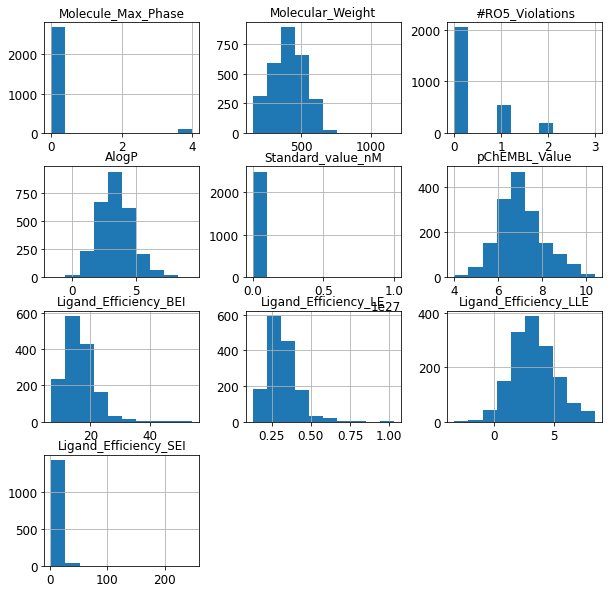

In [47]:
chembl[numeric_cols].hist(figsize=(10,10))

Standard_Type,% Ctrl,% Inhibition of Control Specific Binding (Mean n=2),Activity,EC50,Efficacy,Emax,IC50,Inhibition,Kb,Kd,Ki,Log Ki,Max,Max response,Mean fold stimulation,Ratio,pEC5,pK1b,pKB,pKb
count,4.00000,8.000000,41.000000,228.000000,2.000000,7.000000,146.000000,232.000000,5.000000,13.000000,1.393000e+03,8.000000,43.000000,24.000000,1.000,2.000000,1.0,18.000000,3.000000,10.000000
mean,98.00000,8.525000,18.816829,26185.018277,22.950000,36.428571,5162.562534,24.299218,159.320800,1091.022308,7.178751e+23,6.950625,85.558140,31.166667,0.275,143.200000,4.0,53.626111,6.173333,7.173000
std,6.78233,7.982078,23.796754,40521.215938,6.858936,16.267116,8677.976943,27.754431,133.308639,963.201346,2.679319e+25,1.145408,23.102569,43.062812,NaN,94.823019,NaN,192.760536,0.543722,1.732878
min,93.00000,-4.700000,-1.000000,0.130000,18.100000,14.000000,1.200000,-31.630000,0.004000,45.710000,3.981000e-02,6.000000,29.000000,0.000000,0.275,76.150000,4.0,6.590000,5.550000,5.540000
25%,94.50000,3.175000,0.000000,83.690000,20.525000,26.000000,265.212500,0.557500,60.600000,457.090000,3.388000e+01,6.082500,77.500000,0.000000,0.275,109.675000,4.0,7.532500,5.985000,6.162500
50%,95.50000,9.150000,14.530000,5011.870000,22.950000,36.000000,1001.500000,15.877500,154.000000,933.250000,1.670000e+02,6.692500,92.000000,0.000000,0.275,143.200000,4.0,8.450000,6.420000,6.690000
75%,99.00000,15.425000,24.180000,10000.000000,25.375000,47.500000,6598.000000,50.000000,266.000000,1258.930000,1.000000e+03,7.130000,103.500000,76.250000,0.275,176.725000,4.0,8.817500,6.485000,7.707500
max,108.00000,17.400000,123.000000,100000.000000,27.800000,58.000000,30199.520000,98.000000,316.000000,3630.780000,1.000000e+27,9.270000,114.000000,104.000000,0.275,210.250000,4.0,826.000000,6.550000,11.410000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f136c162890>,
      dtype=object)

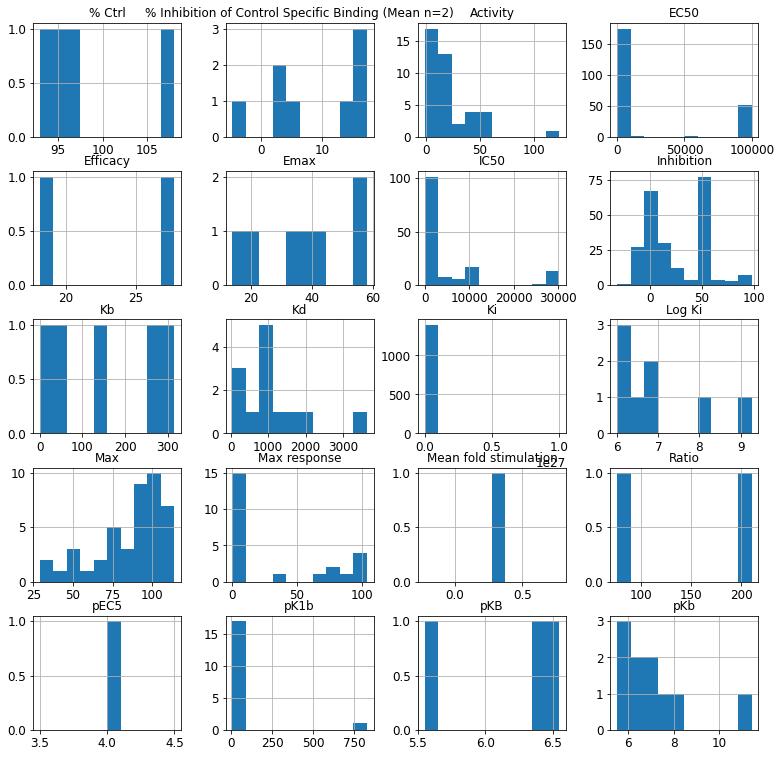

In [50]:
#examine standard values and pChembl values PER standard type
chembl_types = chembl.pivot_table(index='Molecule_ChEMBL_ID',columns='Standard_Type',values='Standard_value_nM',aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13))

Standard_Type,EC50,IC50,Kd,Ki
count,90.000000,115.000000,13.000000,1201.000000
mean,7.408889,6.240130,6.187692,7.030226
std,0.950050,0.824982,0.566909,1.019068
min,5.700000,4.570000,5.440000,4.000000
25%,6.720000,5.680000,5.900000,6.410000
50%,7.200000,6.110000,6.030000,6.920000
75%,8.215000,6.695000,6.340000,7.640000
max,9.890000,8.920000,7.340000,10.400000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1367be7d10>,
      dtype=object)

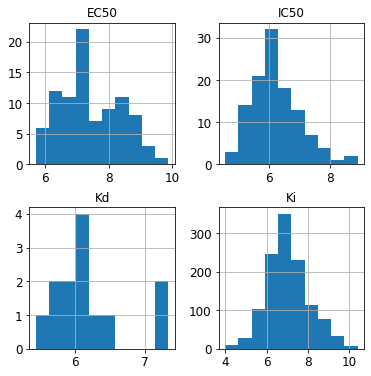

In [52]:
chembl_types = chembl.pivot_table(index='Molecule_ChEMBL_ID',columns='Standard_Type',values='pChEMBL_Value',aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6))

In [82]:
uploaded = files.upload()

Saving DTC_smiles.txt to DTC_smiles.txt


In [83]:
dtc_smiles = pd.read_csv('DTC_smiles.txt',sep='\t',header=None)
dtc_smiles = dtc_smiles.rename(columns={0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL100045,CCC1=C(C(C(=C(N1)COC)C(=O)NCCCN2CCC(CC2)(C3=CC...
1,CHEMBL100052,C1CN(CCC12CC3=CC=CC=C3C2=O)CCC4=CC=CC5=CC=CC=C54
2,CHEMBL100198,CN(C)C(=O)C1=CC=CC=C1NCC2=NCCN2
3,CHEMBL100198,CN(C)C(=O)C1=CC=CC=C1NCC2=NCCN2
4,CHEMBL100383,CCC(CC)OC(=O)C1=CC=CC=C1NCC2=NCCN2


In [84]:
dtc_smiles['ChEMBL_ID']

0       CHEMBL100045
1       CHEMBL100052
2       CHEMBL100198
3       CHEMBL100198
4       CHEMBL100383
            ...     
4787     CHEMBL99761
4788     CHEMBL99864
4789     CHEMBL99879
4790     CHEMBL99979
4791     CHEMBL99994
Name: ChEMBL_ID, Length: 4792, dtype: object

In [85]:
dtc['SMILES'] = dtc['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID,dtc_smiles.SMILES)))

In [86]:
print('No ChemblID in DTC',len(dtc[dtc['Compound_ID'].isna()]))
print('No Smiles from ChembleID in DTC',len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC 47
No Smiles from ChembleID in DTC 47


EDA：Examine compound overlaps

In [59]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

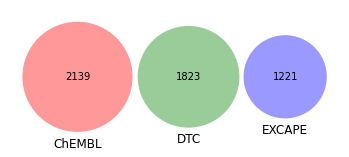

In [87]:
#overlaps from smiles strings
venn3([set(chembl.Smiles),set(dtc.SMILES),
       set(excape.SMILES)],set_labels=['ChEMBL','DTC','EXCAPE'])

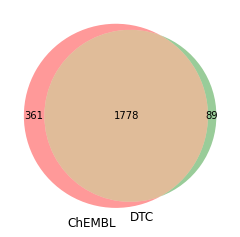

In [88]:
#venn diagram for overlapping ChEMBL IDs
venn2([set(chembl.Molecule_ChEMBL_ID),set(dtc.Compound_ID)],set_labels=['ChEMBL','DTC'])

##### The chembl IDs overlaps but the smile strings not. Each databases's SMILES representations are slightly different, we need standardize the smiles string.

Curation steps: Standardize smiles strings, drop rows without base smiles

In [63]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

2791
2140
2129


In [64]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Units_nM,Standard_value_nM,base_rdkit_smiles
83,CHEMBL150161,NaN,0.0,361.84,0.0,4.04,2b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
131,CHEMBL542139,NaN,0.0,488.46,0.0,4.08,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
140,CHEMBL844,BRIMONIDINE,4.0,292.14,0.0,1.76,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
222,CHEMBL836,TAMSULOSIN,4.0,408.52,0.0,2.34,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
243,CHEMBL1231795,NaN,0.0,509.74,2.0,5.84,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,CHEMBL31354,WAY-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2573,CHEMBL543741,NaN,0.0,458.43,0.0,2.53,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2602,CHEMBL4532510,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Inhibition,'=',17.25,17.25,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507829,GPCRScan assay: inhibition of Alpha1B,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,Parental cells: stable HEK | PMID: 7780636/168...,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507304,54.0,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,NaN,Compound concentration None 10.0 uM,17.25,17.25,
2605,CHEMBL479683,NaN,0.0,266.30,0.0,3.28,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [65]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Units_nM,Standard_value_nM,base_rdkit_smiles
83,CHEMBL150161,NaN,0.0,361.84,0.0,4.04,2b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,CHEMBL542139,NaN,0.0,488.46,0.0,4.08,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,CHEMBL844,BRIMONIDINE,4.0,292.14,0.0,1.76,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,CHEMBL836,TAMSULOSIN,4.0,408.52,0.0,2.34,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,CHEMBL1231795,NaN,0.0,509.74,2.0,5.84,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,CHEMBL31354,WAY-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2573,CHEMBL543741,NaN,0.0,458.43,0.0,2.53,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2602,CHEMBL4532510,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Inhibition,'=',17.25,17.25,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507829,GPCRScan assay: inhibition of Alpha1B,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,Parental cells: stable HEK | PMID: 7780636/168...,NaN,NaN,CHEMBL232,Alpha-1b adrenergic receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507304,54.0,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,NaN,Compound concentration None 10.0 uM,17.25,17.25,NaN
2605,CHEMBL479683,NaN,0.0,266.30,0.0,3.28,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
chembl = chembl[~chembl.base_rdkit_smiles.isna()]

In [70]:
pivot = chembl.pivot_table(index='Molecule_ChEMBL_ID',columns='base_rdkit_smiles',values='pChEMBL_Value',aggfunc='mean')
pivot.describe()

base_rdkit_smiles,Brc1c(NC2=NCCN2)ccc2c1NCCN2,Brc1c(NC2=NCCS2)ccc2nccnc12,Brc1ccc2c(-c3c[nH]c(-c4c[nH]c5cc(Br)ccc45)n3)c[nH]c2c1,Brc1ccc2c(-c3c[nH]c(-c4c[nH]c5ccccc45)n3)c[nH]c2c1,Brc1ccc2c(-c3nc(-c4c[nH]c5ccccc45)c[nH]3)c[nH]c2c1,C1=C(N2CCNCC2)c2nccn2Cc2ccccc21,C1=CC2(CCN(CCc3cccc4ccccc34)CC2)Oc2ccccc21,C=CCN(CC=C)CCc1c[nH]c2ccc(Br)cc12,C=CCN(CC=C)CCc1c[nH]c2ccc(C)cc12,C=CCN(CC=C)CCc1c[nH]c2ccc(Cl)cc12,C=CCN(CC=C)CCc1c[nH]c2ccccc12,C=Cc1sc2ccc(Cl)c3c2c1CN(C)CC3,CC(=O)C1(c2ccccc2)CCN(CCCNC(=O)C2=C(C)NC(C)=C(C(N)=O)C2c2ccc([N+](=O)[O-])cc2)CC1,CC(=O)C1=C(C)NC(=O)N(C(=O)NCCCN2CCN(c3ccccc3C(N)=O)CC2)C1c1cc(F)c(F)c(F)c1,CC(=O)C1=C(C)NC(=O)N(C(=O)NCCCN2CCN(c3ccccc3C(N)=O)CC2)C1c1ccc(F)c(F)c1,CC(=O)C1=C(C)NC(C)=C(C(=O)NCCCN2CCC(c3ccccc3)(c3ccccc3)CC2)C1c1ccc([N+](=O)[O-])cc1,CC(=O)C1=C(C)NC(C)=C(C(=O)NCCCN2CCC(c3ccccc3)(c3ccccc3)CC2)C1c1ccc2c(c1)OCO2,CC(=O)N1C(=O)N(C)C(C)=C(C(=O)NCCCN2CCC(c3ccc(F)cc3)CC2)[C@H]1c1ccc(F)c(F)c1,CC(=O)c1c(-c2ccccc2)nn(C)c(=O)c1NCCN1CCN(c2ccccc2Cl)CC1,CC(=O)c1c(-c2ccccc2)nn(C)c(=O)c1NCCN1CCN(c2ccccc2F)CC1,CC(=O)c1ccc(N2CCN(CCc3ccc(CN4C(=O)c5ccccc5C4=O)cc3)CC2)cc1,CC(C)(C)OC(=O)c1ccccc1NCC1=NCCN1,CC(C)(Cc1c[nH]c2ccc(Cl)cc12)NCCOc1ccccc1OCC1CC1,CC(C)=CCOc1ccc(Cl)c2c1CCN(C)CC2,CC(C)C(C(=O)NCCCN1CCC(C#N)(c2ccccc2)CC1)c1ccccc1,CC(C)C1=C(C(N)=O)C(c2ccc([N+](=O)[O-])cc2)C(C(=O)NCCCN2CCC(c3ccccc3)(c3ccccc3)CC2)=C(C(C)C)N1,CC(C)CC(=O)O[C@H]1/C=C/C=C/C(=O)O[C@H]2[C@@H](C)C[C@@H]3[C@]2(O)[C@H](O)[C@@]2(CO)O[C@H]2[C@H]2[C@H]4OC5(c6ccccc6)O[C@@H]([C@@H](C)[C@@]23O5)[C@@]4(O)[C@](C)(O)C[C@H]2CC[C@H]1[C@H]2C,CC(C)CNC(=O)c1ccccc1NCC1=NCCN1,CC(C)COC(=O)c1ccccc1NCC1=NCCN1,CC(C)NC(=O)c1ccccc1NCC1=NCCN1,CC(C)Nc1ccc(-c2cccc(N)c2)c(CC(=O)NCc2ccc(C(=N)N)cc2)c1F,CC(C)OC(=O)c1ccccc1NCC1=NCCN1,CC(C)O[C@H]1c2ccccc2[C@H]2C[C@@]12c1c[nH]cn1,CC(C)Oc1cc(F)ccc1N1CCN(CCNC(=O)CN2CCCCC2=O)CC1,CC(C)Oc1ccccc1C1CCN([C@H]2CC[C@@H](NS(=O)(=O)c3ccc(F)c(F)c3)CC2)CC1,CC(C)Oc1ccccc1C1CCN([C@H]2CC[C@H](NS(=O)(=O)c3ccc(F)c(F)c3)CC2)CC1,CC(C)Oc1ccccc1N1CCN(C/C=C/C(=O)CN2CCCCC2=O)CC1,CC(C)Oc1ccccc1N1CCN(C2CCC(N3C(=O)c4c(F)c(F)c(F)c(F)c4C3=O)CC2)CC1,CC(C)Oc1ccccc1N1CCN(C2CCC(N3C(=O)c4cc(Cl)c(Cl)cc4C3=O)CC2)CC1,CC(C)Oc1ccccc1N1CCN(C2CCC(N3C(=O)c4ccc5ccc(F)cc5c4C3=O)CC2)CC1,...,c1ccc(C2CCN(CCc3ccc(COc4ccc5c(c4)CCCC5)cc3)CC2)cc1,c1ccc(CCN[C@H]2C3C4CC5C6C4CC3C6C52)nc1,c1ccc(CN[C@H]2C3C4CC5C6C4CC3C6C52)cc1,c1ccc(COc2ccccc2OCCNCCOc2ccccc2)cc1,c1ccc(N2CCN(CC3CCCCN3)C2)cc1,c1ccc(OCCNCC2CCC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNCC2CCOC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNCC2COC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNCC2COC(c3ccccc3)(c3ccccc3)OC2)cc1,c1ccc(OCCNCC2COC3(CCCCC3)O2)cc1,c1ccc(OCCNCC2COCC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNCC2CSC3(CCCCC3)O2)cc1,c1ccc(OCCNCC2CSC3(CCCCC3)S2)cc1,c1ccc(OCCNCCC2COC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNCCOC(c2ccccc2)c2ccccc2)cc1,c1ccc(OCCNCC[C@@H]2CO[C@H](C(c3ccccc3)c3ccccc3)O2)cc1,c1ccc(OCCNCC[C@H]2CO[C@H](C(c3ccccc3)c3ccccc3)O2)cc1,c1ccc(OCCNC[C@@H]2COC(c3ccccc3)(c3ccccc3)CO2)cc1,c1ccc(OCCNC[C@@H]2COC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNC[C@@H]2COCC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNC[C@@H]2CO[C@H](C(c3ccccc3)c3ccccc3)O2)cc1,c1ccc(OCCNC[C@H]2COC(c3ccccc3)(c3ccccc3)O2)cc1,c1ccc(OCCNC[C@H]2CO[C@H](C(c3ccccc3)c3ccccc3)O2)cc1,c1ccc2c(NCCCCCCCNc3ccnc4ccccc34)ccnc2c1,c1ccc2c(NCCNc3ccnc4ccccc34)ccnc2c1,c1ccc2c(c1)CCC1(CCN(CCc3cccc4ccccc34)CC1)O2,c1ccc2c(c1)CCCC2c1ncc[nH]1,c1ccc2c(c1)C[C@]1(c3c[nH]cn3)C[C@H]21,c1ccc2c(c1)[C@H]1C[C@@]1(c1c[nH]cn1)C21CC1,c1cnc(-c2ccccc2NCC2=NCCN2)nc1,c1cnc2c(N3CCN(CCCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)cccc2c1,c1cnc2c(N3CCN(CCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)cccc2c1,c1cnc2c(N3CCN(CCc4ccc(OCCCN5CCCCCC5)cc4)CC3)cccc2c1,c1cnc2cc(NC3=NCCN3)ccc2n1,c1cncc(-c2ccccc2OCC2=NCCN2)c1,c1cncc(-c2ccccc2[C@@H]2Cc3nccn3C2)c1,c1coc(-c2ccccc2NCC2=NCCN2)c1,c1coc(-c2ccccc2OCC2=NCCN2)c1,c1csc(-c2ccccc2NCC2=NCCN2)c1,c1csc(-c2ccccc2OCC2=NCCN2)c1
count,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.0

In [89]:
#standardize other datasets
dtc['base_rdkit_smiles'] = dtc['SMILES'].apply(curate_data.base_smiles_from_smiles)
excape['base_rdkit_smiles'] = excape['SMILES'].apply(curate_data.base_smiles_from_smiles)

In [90]:
chembl.to_csv('chembl_new',encoding='utf-8-sig')
dtc.to_csv('dtc_new',encoding='utf-8-sig')
excape.to_csv('excape_new',encoding='utf-8-sig')
files.download('chembl_new')
files.download('dtc_new')
files.download('excape_new')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
print(len(chembl['base_rdkit_smiles'].unique()))
print(len(dtc['base_rdkit_smiles'].unique()))
print(len(excape['base_rdkit_smiles'].unique()))

2128
1810
1202


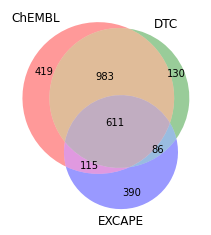

In [92]:
venn3([set(chembl['base_rdkit_smiles']),set(dtc['base_rdkit_smiles']),set(excape['base_rdkit_smiles'])],set_labels=('ChEMBL','DTC','EXCAPE'))

EDA: Examine compound diversity